In [1]:
import torch
import os
import json
import tqdm
import collections
import random
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection

In [2]:
fnames = os.listdir("data")
fields = ['name','smiles','notes']
molecules = []
for fname in tqdm.tqdm(fnames):
    with open(os.path.join("data",fname)) as f:
        mol = json.load(f)
        data = {k:mol[k] for k in fields}
        # Check that the molecule has all the fields of interest
        if all(data.values()):
            molecules.append(data)

# Have to de-dupe the notes for each molecule.
for mol in molecules:
    mol["notes"] = set(mol["notes"])
    
print(f"Found {len(molecules)} molecules.")
molecules[:3]

100%|███████████████████████████████████| 19194/19194 [00:02<00:00, 7016.54it/s]

Found 3440 molecules.


[{'name': 'amyl butyrate',
  'smiles': 'CCCCCOC(=O)CCC',
  'notes': {'banana', 'cherry', 'fruity', 'pineapple', 'sweet', 'tropical'}},
 {'name': 'para-anisyl phenyl acetate',
  'smiles': 'COC1=CC=C(C=C1)COC(=O)CC2=CC=CC=C2',
  'notes': {'anise', 'balsamic', 'honey', 'woody'}},
 {'name': 'dihydrofarnesol',
  'smiles': 'CC(CC/C=C(\\C)/CCC=C(C)C)CCO',
  'notes': {'cyclamen', 'floral', 'metallic'}}]

In [3]:
all_notes = collections.Counter()
for mol in molecules:
    all_notes.update(mol["notes"])
print(f"Found {len(all_notes)} unique notes.")
print("Most common:")
print(all_notes.most_common(5))

Found 502 unique notes.
Most common:
[('fruity', 1060), ('green', 967), ('sweet', 884), ('floral', 706), ('woody', 558)]


In [4]:
all_notes_list = list(all_notes.keys())

def multi_hot(notes):
    indices = torch.tensor([all_notes_list.index(n) for n in notes])
    if len(indices) == 0:
        # Occurs when the notes in the pair were removed due to infrequency.
        raise AttributeError("Found no valid notes.")
    one_hots = torch.nn.functional.one_hot(indices, len(all_notes))
    return one_hots.sum(dim=0).float()

for mol in molecules:
    mol["encoding"] = multi_hot(mol["notes"])

print(molecules[0])

{'name': 'amyl butyrate', 'smiles': 'CCCCCOC(=O)CCC', 'notes': {'fruity', 'cherry', 'pineapple', 'banana', 'tropical', 'sweet'}, 'encoding': tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [39]:
SOM = collections.namedtuple("SOM",["vectors","idxs"])

def make_som(width,height):
    somap = torch.rand((width,height,len(all_notes)))

    map_x_idx, map_y_idx = torch.meshgrid(torch.arange(start=0,end=width), torch.arange(start=0,end=height), indexing='ij')
    map_idx = torch.stack([map_x_idx,map_y_idx],dim=-1)

    return SOM(somap,map_idx)


In [40]:
def get_bmu(som,encoding):
    sims = torch.nn.functional.cosine_similarity(encoding, som.vectors, dim=-1)
    bmu_idx = (sims==torch.max(sims)).nonzero()
    return bmu_idx[0]

def get_score(som,encoding):
    sims = torch.nn.functional.cosine_similarity(encoding, som.vectors, dim=-1)
    return torch.max(sims)

def get_distances(som,bmu):
    xy_dist = som.idxs - bmu
    return torch.sum(torch.abs(xy_dist),dim=-1)

def update_factor(som,bmu):
    dists = get_distances(som,bmu)
    return torch.pow(1/2,dists)

def get_deltas(som,encoding):
    return encoding-som.vectors

def update_som(som,encoding,lr):
    bmu = get_bmu(som,encoding)
    uf = update_factor(som,bmu)
    deltas = get_deltas(som,encoding)
    return SOM(som.vectors + lr*uf.unsqueeze(-1)*deltas, som.idxs)

mm = make_som(3,2)
e0 = molecules[0]["encoding"]
bmu0 = get_bmu(mm,e0)
# When we do the update with lr=1, we expect the bmu to updated to the encoding
mp0 = update_som(mm,e0,1)
assert torch.all(mp0.vectors[bmu0[0],bmu0[1]] == e0)

In [49]:
train_mols, test_mols = sklearn.model_selection.train_test_split(molecules)
# epochs = 1
# lr = 1e-1

def do_train(width,height,epochs,lr):
    total_steps = epochs*len(train_mols)
    lrs = []
    scores = []

    som = make_som(width,height)
    
    def do_train_step(s):
        slr = lr*(1 - (s/total_steps))
        mol = random.choice(train_mols)
        return update_som(som,mol["encoding"],slr)
    
    def get_test_score():
        es = []
        for mol in test_mols:
            es.append(get_score(som,mol["encoding"]))
        return np.mean(es)
    
    for s in tqdm.tqdm(range(total_steps),smoothing=0):
        som = do_train_step(s)
        if s % 100 == 0:
            scores.append(get_test_score())
    
    return som, scores

100%|█████████████████████████████████████| 2580/2580 [00:00<00:00, 6770.14it/s]


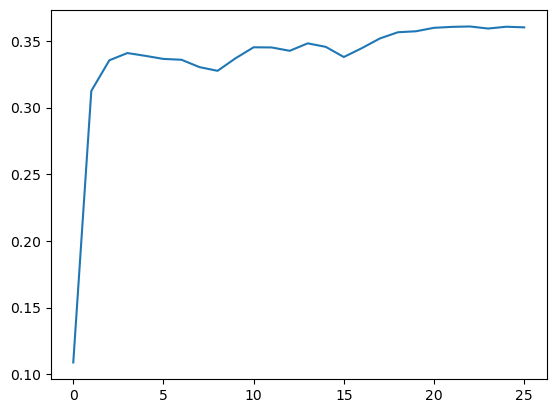

In [50]:
som, scores = do_train(width=3,height=2,epochs=1,lr=1e-1)
plt.plot(scores)

100%|██████████████████████████████████████| 2580/2580 [00:08<00:00, 317.09it/s]


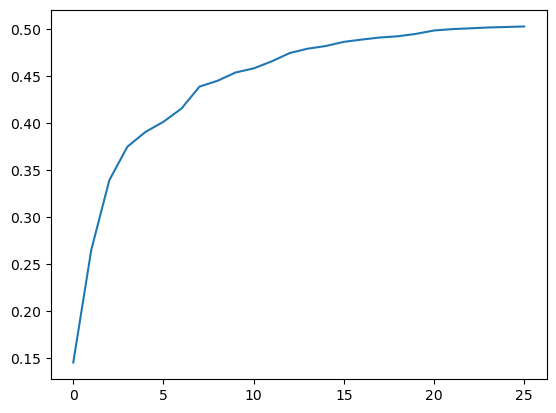

In [51]:
som, scores = do_train(width=25,height=20,epochs=1,lr=1e-1)
plt.plot(scores)

In [ ]:
som, scores = do_train(width=100,height=100,epochs=1,lr=1e-1)
plt.plot(scores)

  4%|█▌                                      | 100/2580 [00:07<03:02, 13.57it/s]